# Code for 7CUSMSDA_Final Project
- Author: Juncai Yang
- Student Number: 21054748
- Link for GitHub:https://github.com/YangJuncai199909/YangJuncai199909-7CUSMSDA_Final-Project/tree/main

# import

In [1]:
# -*- coding:utf-8 -*-
import geopandas
from shapely.geometry import Point, LineString
from geopandas import GeoDataFrame
# conda install -c conda-forge spaghetti (if using conda)
import spaghetti
import os
import glob
from libpysal.weights import Queen
import pandas as pd
import geopandas as gpd
import networkx as nx
import osmnx
from matplotlib import pyplot as plt
import matplotlib
from pyproj import Proj
import smopy
import seaborn as sns
import collections
import numpy as np
import math
from matplotlib import cm
import esda
from haversine import haversine
from splot.esda import lisa_cluster
from splot.esda import moran_scatterplot, lisa_cluster, plot_moran
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")

D:\ProgramData\Anaconda3\envs\msda2021\lib\site-packages\spaghetti\network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


# Find City of London and Road Network

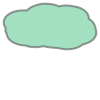

In [2]:
# cited from Week8 codes in Network Data Analysis(7CUSMNDA)
# https://github.kcl.ac.uk/k2143309/7CUSMNDA/tree/master/notebooks
# define the place which we need to research
PLACE_OF_INTEREST = "City of London, London,United Kingdom"
# get the gdf by using osmnx.geocode_to_gdf() and set the distance of buffer at 1000 meters.
london_center = osmnx.geocode_to_gdf(PLACE_OF_INTEREST, buffer_dist=1000)

# From this take the polygon that defines London's boundary
london_polygon = london_center['geometry'][0]
# we can see that the buffer is like an oval
london_polygon

In [3]:
london_df = pd.read_csv("./final_data/London_Traffic_accident_2020.csv")
london_df = london_df.dropna().reset_index(drop=True)

In [4]:
geometry = [Point(xy) for xy in zip(london_df.longitude, london_df.latitude)]
london_df.drop(['longitude', 'latitude'], axis=1, inplace=True)
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(london_df, crs=crs, geometry=geometry)
gdf = gdf.to_crs({'init': 'epsg:27700'})
# gdf = gpd.GeoDataFrame(
#     london_df, geometry=geopandas.points_from_xy(london_df["longitude"], london_df["latitude"],crs="EPSG:4326"))
# #gdf_new=gdf.to_crs(epsg=4326)

In [5]:
gdf.head()

accident_year accident_reference  location_easting_osgr  \
0           2020           10219808               521389.0   
1           2020           10220496               529337.0   
2           2020           10228005               526432.0   
3           2020           10228006               538676.0   
4           2020           10228011               529324.0   

   location_northing_osgr  police_force  accident_severity  \
0                175144.0             1                  3   
1                176237.0             1                  3   
2                182761.0             1                  3   
3                184371.0             1                  2   
4                181286.0             1                  3   

   number_of_vehicles  number_of_casualties        date  day_of_week  ...  \
0                   1                     1  04/02/2020            3  ...   
1                   1                     2  27/04/2020            2  ...   
2                   1                     1  01/01/2020            4  ...   
3                   1                     1  01/01/2020            4  ...   
4                   1                     2  01/01/2020            4  ...   

  light_conditions  weather_conditions road_surface_conditions  \
0                1                   9                       9   
1                1                   1                       1   
2                4                   1                       2   
3                4                   1                       1   
4                4                   1                       1   

  special_conditions_at_site  carriageway_hazards  urban_or_rural_area  \
0                          0                    0                    1   
1                          0                    0                    1   
2                          0                    0                    1   
3                          0                    0                    1   
4                          0                    0                    1   

   did_police_officer_attend_scene_of_accident  trunk_road_flag  \
0                                            3                2   
1                                            1                2   
2                                            1                2   
3                                            1                2   
4                                            1                2   

   lsoa_of_accident_location                       geometry  
0                  E01004576  POINT (521389.026 175144.021)  
1                  E01003034  POINT (529337.010 176237.056)  
2                  E01004726  POINT (526432.004 182760.982)  
3                  E01003617  POINT (538676.002 184371.007)  
4                  E01004763  POINT (529323.988 181285.973)  

[5 rows x 34 columns]

<AxesSubplot:>

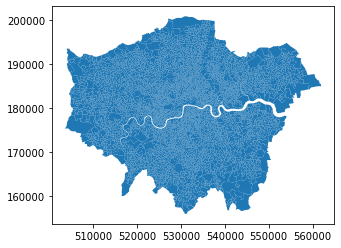

In [6]:
lsoas=gpd.read_file('./final_data/lsoa_IMD_airbnb_housing.shp')
lsoas.plot()

In [7]:
lsoas.columns.to_list()

['Code',
 'Area',
 'Year',
 'Value',
 'Measure',
 'LSOA11NM',
 'USUALRES',
 'HHOLDRES',
 'COMESTRES',
 'POPDEN',
 'HHOLDS',
 'AVHHOLDSZ',
 'IMDScore',
 'IncScore',
 'EmpScore',
 'EduScore',
 'HeaScore',
 'CriScore',
 'BaHScore',
 'EnvScore',
 'Mean Price',
 'Small Host',
 'Multiple L',
 'Property C',
 'geometry']

In [8]:
# cited from Week7 codes in Spatial Data Analysis(7CUSMSDA)
# df with point geometry
df = gpd.sjoin(gdf, lsoas, how="inner", op='within')
# check the columns upon spatial join
df.drop([ 'Year','Value','Measure','LSOA11NM','USUALRES','HHOLDRES','COMESTRES','POPDEN','HHOLDS','AVHHOLDSZ','IMDScore','IncScore',
         'EmpScore','EduScore','HeaScore','CriScore','BaHScore','EnvScore','Mean Price','Small Host','Multiple L','Property C',
         'location_easting_osgr','location_northing_osgr','road_type','accident_reference','date','day_of_week','time',
         'local_authority_district','local_authority_ons_district','local_authority_highway','first_road_class','first_road_number',
         'second_road_class','second_road_number'], axis=1, inplace=True)
df = df.dropna().reset_index(drop=True)
df.geometry

0        POINT (521389.026 175144.021)
1        POINT (521356.990 174350.051)
2        POINT (521345.011 174674.992)
3        POINT (521223.979 174363.019)
4        POINT (529337.010 176237.056)
                     ...              
20966    POINT (532141.991 181416.995)
20967    POINT (532124.988 181309.950)
20968    POINT (532166.005 181548.035)
20969    POINT (532105.984 181851.036)
20970    POINT (532122.038 181853.012)
Name: geometry, Length: 20971, dtype: geometry

In [9]:
# cited from Week7 codes in Spatial Data Analysis(7CUSMSDA)
# df1 with polygon geometry 
df1 = gpd.sjoin(lsoas,gdf,how="inner")
# check the columns upon spatial join
df1.drop([ 'Year','Value','Measure','LSOA11NM','USUALRES','HHOLDRES','COMESTRES','POPDEN','HHOLDS','AVHHOLDSZ','IMDScore','IncScore',
         'EmpScore','EduScore','HeaScore','CriScore','BaHScore','EnvScore','Mean Price','Small Host','Multiple L','Property C',
         'location_easting_osgr','location_northing_osgr','road_type','accident_reference','date','day_of_week','time',
         'local_authority_district','local_authority_ons_district','local_authority_highway','first_road_class','first_road_number',
         'second_road_class','second_road_number'], axis=1, inplace=True)
df1 = df1.dropna().reset_index(drop=True)
df1.geometry

0        POLYGON ((532105.330 182017.386, 532162.728 18...
1        POLYGON ((532105.330 182017.386, 532162.728 18...
2        POLYGON ((532105.330 182017.386, 532162.728 18...
3        POLYGON ((532105.330 182017.386, 532162.728 18...
4        POLYGON ((532105.330 182017.386, 532162.728 18...
                               ...                        
20966    POLYGON ((546415.827 180158.362, 546320.798 18...
20967    POLYGON ((546415.827 180158.362, 546320.798 18...
20968    POLYGON ((546415.827 180158.362, 546320.798 18...
20969    POLYGON ((538140.138 177319.110, 538129.314 17...
20970    POLYGON ((538140.138 177319.110, 538129.314 17...
Name: geometry, Length: 20971, dtype: geometry

<AxesSubplot:>

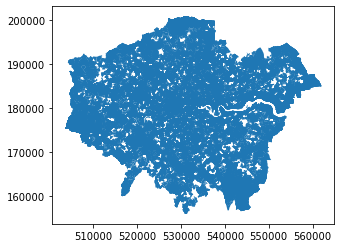

In [10]:
df1.plot()

# Find all the accident points in London

In [11]:
# get all the accident points with their position in London
all_accident_points = df.geometry
# Now, choosing the accident points which are inside the chosen area.
all_london_accident = df
len(all_london_accident)
# we could find that there are 20974 accidents in the chosen area.

20971

In order to make calculating easier, we used the points within City of London

In [12]:
# because the data is too large, so we use the data within City of London
gdf_ac = all_london_accident.to_crs({'init': 'epsg:4326'})
city_accident_points = gdf_ac.geometry
city_london_accident = gdf_ac[city_accident_points.within(london_polygon)]
city_london_accident = city_london_accident.reset_index(drop=True)
len(city_london_accident) # the accidents happened with the City of London

681

Lowered zoom level to keep map size reasonable. (z = 10)


<AxesSubplot:>

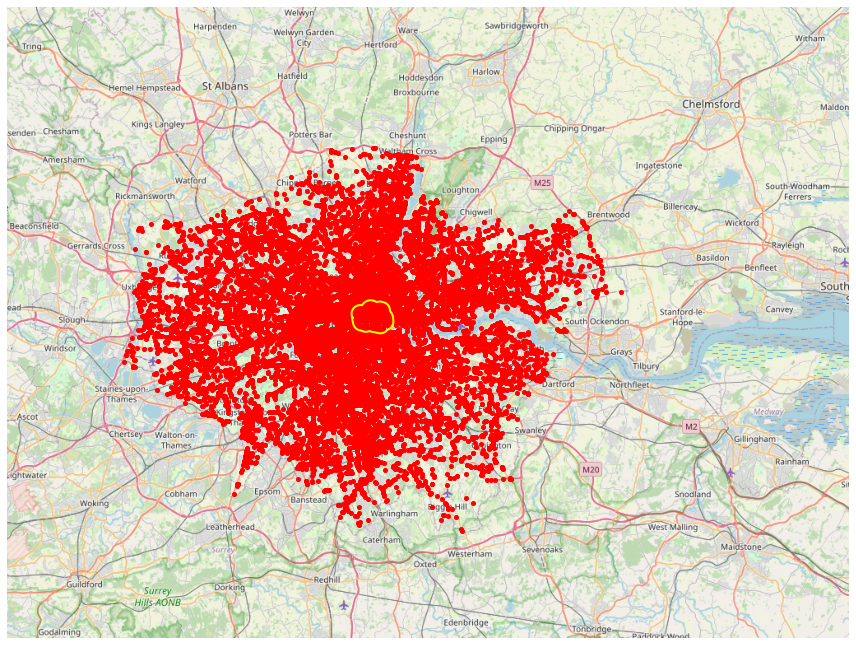

In [13]:
# Show the all points and chosen points
# in order to show the result of the accident points with the defined area, I draw them together.
box_geo = gdf_ac.geometry
box_stations = (box_geo.y.min(),box_geo.x.min(),
       box_geo.y.max(), box_geo.x.max())
map = smopy.Map(box_stations, z=1000) # z is the zoom level, here we set it as 10, you may want to try another value.
# map.show_ipython()
p1 = pd.Series(london_polygon.exterior.coords.xy[1].tolist())
p2 = pd.Series(london_polygon.exterior.coords.xy[0].tolist())
x1, y1 = map.to_pixels(box_geo.y, box_geo.x)
x2, y2 = map.to_pixels(p1,p2)
x1, y1 = map.to_pixels(box_geo.y, box_geo.x)
ax = map.show_mpl(figsize=(12, 10))
ax.plot(x1, y1, 'or', ms=4, mew=1) # 'or' means red dots/circles
ax.plot(x2, y2, color='yellow', linestyle='solid',linewidth=2, markersize=12)
lsoas.plot(ax=ax)

# Are nearby car accidents related to each other?

## 1. Get the road map

In [14]:
# cited from Week8 codes in Network Data Analysis(7CUSMNDA)
# https://github.kcl.ac.uk/k2143309/7CUSMNDA/tree/master/notebooks

# get the network of streets in London city centre
london_graph = osmnx.graph_from_polygon(london_polygon,network_type = 'drive')
# Some edges (roads in City of London) are missing a geometry, so we will create one
# assuming that the road is a direct line from start point to end point.
# First, we need to get the locations of the points
x_values = nx.get_node_attributes(london_graph, 'x')
y_values = nx.get_node_attributes(london_graph, 'y')

# We will work with the edges and add the missing geometries (lines denoting the roads between points)
graph_with_road = list(london_graph.edges(data=True))

# Iterate through the edges and, where missing, add a geometry attribute with the line between start and end nodes
for e in graph_with_road:
    if not 'geometry' in e[2]:
        e[2]['geometry'] = LineString([
            Point(x_values[e[0]], y_values[e[0]]),
            Point(x_values[e[1]], y_values[e[1]])])

In [15]:
# number of roads
len(graph_with_road)

6149

In [16]:
# cited from Week8 codes in Network Data Analysis(7CUSMNDA)
# https://github.kcl.ac.uk/k2143309/7CUSMNDA/tree/master/notebooks

# We will now drop the start and end nodes, as we will construct a new Spaghetti network based on the geometries of the roads
road_lines = [x[2] for x in graph_with_road]
# From this, we can construct a GeoDataFrame
roads_geodataframe = GeoDataFrame(pd.DataFrame(road_lines))
# From the GeoDataFrame, we can construct a network in Spaghetti from which to do point analysis
road_network = spaghetti.Network(in_data=roads_geodataframe)

## Traffic Accident Distribution Visualization in City of London

Due to hardware device limitations, running the whole London data may cause kernel crashes, so we conduct a study of car crash spatial autocorrelation in the City of London.

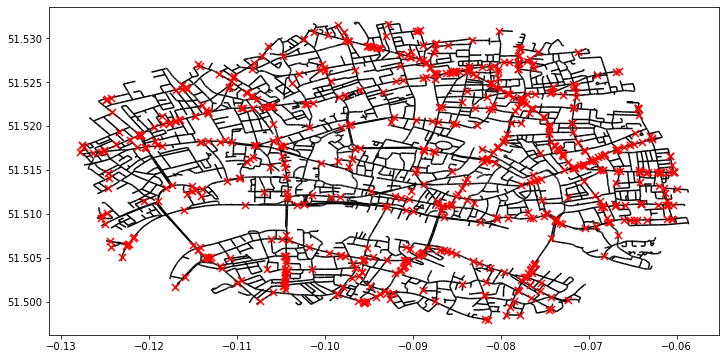

In [17]:
# cited from Week8 codes in Network Data Analysis(7CUSMNDA)
# https://github.kcl.ac.uk/k2143309/7CUSMNDA/tree/master/notebooks

nodes_df, edges_df = spaghetti.element_as_gdf(
   road_network, vertices=True, arcs=True)
# We will now snap the london located accidents we extracted earlier, i.e. position them at the closest point on the closest road
road_network.snapobservations(city_london_accident, 'accidents')

# Show the network
base_network = edges_df.plot(color="k", zorder=0, figsize =(12, 12))
# Get a GeoDataFrame of the snapped crime locations to plot on the network image
snapped_accidents=spaghetti.element_as_gdf(
    road_network, pp_name='accidents', snapped=True)

# Plot these on the road network
snapped_accidents.plot(
    color="r", marker="x",
    markersize=50, zorder=1, ax=base_network)

plt.show()

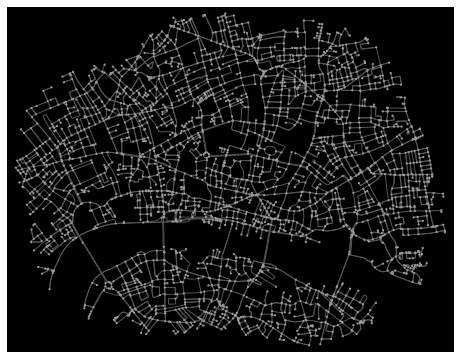

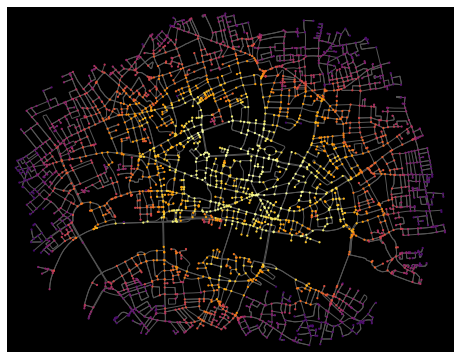

In [18]:
# cited from Week7 codes in Spatial Data Analysis(7CUSMSDA)

# project a street network
G1 = osmnx.projection.project_graph(london_graph)
fig, ax = osmnx.plot.plot_graph(G1, bgcolor='k', node_size=5, node_color='#999999', node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=1, edge_alpha=1)
# node closeness centrality
node_centrality = nx.closeness_centrality(G1)
# plot it
df_tm = pd.DataFrame(data=pd.Series(node_centrality).sort_values(), columns=['cc'])
df_tm['colors'] = osmnx.plot.get_colors(n=len(df_tm), cmap='inferno', start=0.2)
df_tm = df_tm.reindex(G1.nodes())
nc = df_tm['colors'].tolist()
fig, ax = osmnx.plot.plot_graph(G1, bgcolor='k', node_size=5, node_color=nc, node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=1, edge_alpha=1)

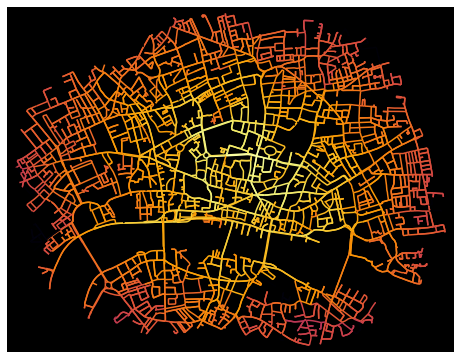

In [19]:
# cited from Week7 codes in Spatial Data Analysis(7CUSMSDA)

# edge closeness centrality: convert graph to a line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G1))

# list of edge values for the orginal graph
ev = [edge_centrality[edge + (0,)] for edge in G1.edges()]

# color scale converted to list of colors for graph edges
norm = matplotlib.colors.Normalize(vmin=min(ev)*0.8, vmax=max(ev))
cmap = cm.ScalarMappable(norm=norm, cmap=cm.inferno)
ec = [cmap.to_rgba(cl) for cl in ev]

# color the edges in the original graph with closeness centralities in the line graph
fig, ax = osmnx.plot.plot_graph(G1, bgcolor='k', ax=None, node_size=0, node_color='w', node_edgecolor='gray', node_zorder=2,
                        edge_color=ec, edge_linewidth=1.5, edge_alpha=1)

In [20]:
# Get snapped point pattern 
pointpat = road_network.pointpatterns['accidents']
# Get count of points per network edge: a dictionary from each edge to the crime count on that edge
counts = road_network.count_per_link(pointpat.obs_to_arc, graph=False)
pp_name='accidents'

moran_ntwwn, yaxis_ntwwn = road_network.Moran(pp_name,graph=True)
print("Moran'I: ",moran_ntwwn.I)
print("Moran'p_sim: ",moran_ntwwn.p_sim)
# 0,001<0.05 indicates that spatial autocorrelation between car crashes

Moran'I:  0.1362726879286193
Moran'p_sim:  0.001


(<Figure size 864x432 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: 0.14', ylabel='Density'>,
        <AxesSubplot:title={'center':'Moran Scatterplot (0.14)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

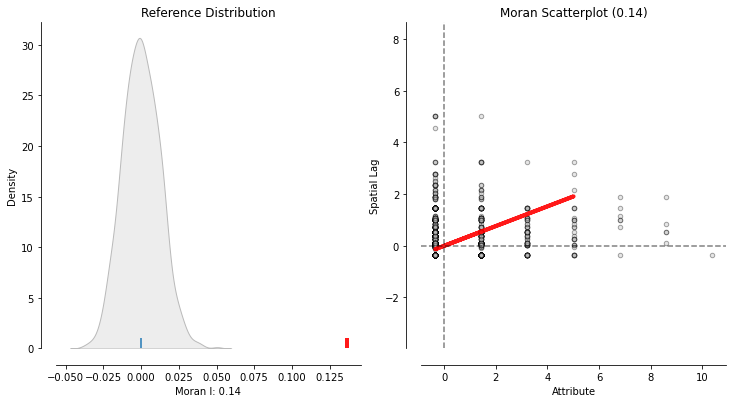

In [21]:
figsize = (12,6)
fitline_kwds = {"color":"r", "lw": 4, "alpha":.9}
scatter_kwds = {"s":20, "edgecolors":"k", "alpha":.35}
pltkwds = {"fitline_kwds": fitline_kwds, "scatter_kwds": scatter_kwds}
plot_moran(moran_ntwwn, zstandard=True, figsize=figsize, **pltkwds)
# almost all the points are gathering in the High-high quadrant.That is, the closer the street is, the easier it is for accidents to gather.

## Some interesting findings

In [22]:
# cited from Coursework2 codes in Network Data Analysis(7CUSMNDA)
# https://github.com/YangJuncai199909
X = snapped_accidents.geometry.x
Y = snapped_accidents.geometry.y
# get which street is the closest to each accident point.
Dist_PtoS = osmnx.distance.nearest_edges(london_graph, X, Y, interpolate=None, return_dist=False)
dist = []
fraction = []
for i in range(len(Dist_PtoS)):
    node_start = Dist_PtoS[i][0]
    node_end = Dist_PtoS[i][1]
    # p1 is the accident point
    p1 = (Y[i],X[i])
    # p2 are the start and the end of the street where p1 was happened .
    p2_start = (london_graph.nodes()[node_start]['y'],london_graph.nodes()[node_start]['x'])
    p2_end = (london_graph.nodes()[node_end]['y'],london_graph.nodes()[node_end]['x'])
    street_length = haversine(p2_end,p2_start,unit='km')
    dist_start = haversine(p1,p2_start,unit='km')
    dist_end = haversine(p1,p2_end,unit='km')
    if dist_start>=dist_end:
        dist.append(dist_end)
        frac = dist_end/street_length
        fraction.append(frac)
    else:
        dist.append(dist_start)
        frac = dist_start/street_length
        fraction.append(frac)

In [23]:
ave_dist = sum(dist)/len(dist)
ave_fraction = sum(fraction)/len(fraction)
road_fraction = round(ave_fraction*100, 2)
print('The average distance between accident point to the intersection is {} km.'.format(ave_dist)) #km
print('The average fraction of the nearest intersection to accident point is {}%.'.format(road_fraction))# Proportion

The average distance between accident point to the intersection is 0.016153256434004802 km.
The average fraction of the nearest intersection to accident point is 19.05%.


# OLS linear regression

In [24]:
# cited from Week7 codes in Spatial Data Analysis(7CUSMSDA)

db_geo = gpd.GeoDataFrame(df1, geometry='geometry')
db_geo.to_file(driver='ESRI Shapefile', filename='./final_data/lsoa_IMD_accidents.shp')
gdf_new=gpd.read_file('./final_data/lsoa_IMD_accidents.shp')
gdf_new.head()

Code                 Area  index_righ  accident_y  police_for  \
0  E01000001  City of London 001A       76969        2020          48   
1  E01000001  City of London 001A       76968        2020          48   
2  E01000001  City of London 001A       76918        2020          48   
3  E01000001  City of London 001A       76995        2020          48   
4  E01000001  City of London 001A       76952        2020          48   

   accident_s  number_of_  number_o_1  speed_limi  junction_d  ...  \
0           3           2           1          20           3  ...   
1           3           1           1          20           3  ...   
2           2           1           1          20           3  ...   
3           2           2           1          20           1  ...   
4           3           1           1          20           0  ...   

   light_cond  weather_co  road_surfa  special_co  carriagewa  urban_or_r  \
0           1           1           1           0           0           1   
1           1           1           1           0           0           1   
2           1           1           1           0           0           1   
3           1           1           1           0           0           1   
4           1           1           1           0           0           1   

   did_police  trunk_road  lsoa_of_ac  \
0           1           2   E01000001   
1           1           2   E01000001   
2           2           2   E01000001   
3           1           2   E01000001   
4           1           2   E01000001   

                                            geometry  
0  POLYGON ((532105.330 182017.386, 532162.728 18...  
1  POLYGON ((532105.330 182017.386, 532162.728 18...  
2  POLYGON ((532105.330 182017.386, 532162.728 18...  
3  POLYGON ((532105.330 182017.386, 532162.728 18...  
4  POLYGON ((532105.330 182017.386, 532162.728 18...  

[5 rows x 23 columns]

In [25]:
gdf_new.columns

Index(['Code', 'Area', 'index_righ', 'accident_y', 'police_for', 'accident_s',
       'number_of_', 'number_o_1', 'speed_limi', 'junction_d', 'junction_c',
       'pedestrian', 'pedestri_1', 'light_cond', 'weather_co', 'road_surfa',
       'special_co', 'carriagewa', 'urban_or_r', 'did_police', 'trunk_road',
       'lsoa_of_ac', 'geometry'],
      dtype='object')

In [26]:
# cited from Week7 codes in Spatial Data Analysis(7CUSMSDA)

import libpysal as lps
# read the .dbf file from your shapefile data
f = lps.io.open('./final_data/lsoa_IMD_accidents.dbf','r')
# Read in the listing_price (dependent variable) into an array y
y = np.array(f.by_col['accident_s'])
y.shape = (len(y),1)
# value for independent variables into a one dimmensional array X. 
# You can feel free to change the independant variables
X= []
X.append(f.by_col['light_cond']) # average house price
X.append(f.by_col['weather_co']) # Income score in 2019
X.append(f.by_col['road_surfa']) # Education score in 2019
X.append(f.by_col['special_co']) # Barrier to Housing Services score in 2019
X = np.array(X).T

In [27]:
# cited from Week7 codes in Spatial Data Analysis(7CUSMSDA)
import spreg
m1 = spreg.OLS(y, X, name_y = 'accident_s', 
                        name_x = [ 'light_cond', 'weather_co','road_surfa', 'special_co'], 
                        name_ds = 'lsoa_IMD_accidents')
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :lsoa_IMD_accidents
Weights matrix      :        None
Dependent Variable  :  accident_s                Number of Observations:       20971
Mean dependent var  :      2.8556                Number of Variables   :           5
S.D. dependent var  :      0.3638                Degrees of Freedom    :       20966
R-squared           :      0.0026
Adjusted R-squared  :      0.0024
Sum squared residual:    2767.688                F-statistic           :     13.4443
Sigma-square        :       0.132                Prob(F-statistic)     :    6.05e-11
S.E. of regression  :       0.363                Log likelihood        :   -8522.080
Sigma-square ML     :       0.132                Akaike info criterion :   17054.160
S.E of regression ML:      0.3633                Schwarz criterion     :   17093.914

-----------------------------------------------------------------------

In [28]:
# cited from Week7 codes in Spatial Data Analysis(7CUSMSDA)
x = ['light_cond', 'weather_co','road_surfa', 'special_co'] # define input/independant variables
X = gdf_new.loc[:, x].dropna()
# X = sm.add_constant(X)
y = np.array(gdf_new['accident_s']) # define output/dependant variable
# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.696
Model:                            OLS   Adj. R-squared (uncentered):              0.696
Method:                 Least Squares   F-statistic:                          1.199e+04
Date:                Sat, 23 Apr 2022   Prob (F-statistic):                        0.00
Time:                        23:39:21   Log-Likelihood:                         -39449.
No. Observations:               20971   AIC:                                  7.891e+04
Df Residuals:                   20967   BIC:                                  7.894e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
light_cond     0.5282      0.005    103.149      0.000       0.518       0.538
weather_co     0.1944      0.006     35.232      0.000       0.184       0.205
road_surfa     0.3650      0.008     46.079      0.000       0.349       0.381
special_co    -0.0547      0.005    -10.631      0.000      -0.065      -0.045
==============================================================================
Omnibus:                     5708.737   Durbin-Watson:                   1.442
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14399.246
Skew:                          -1.496   Prob(JB):                         0.00
Kurtosis:                       5.744   Cond. No.                         3.35
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


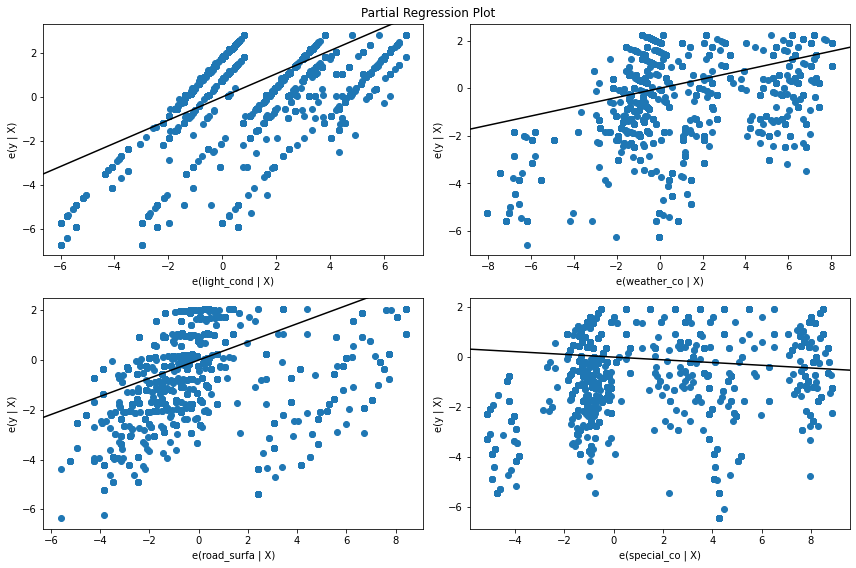

In [29]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(model, fig=fig)

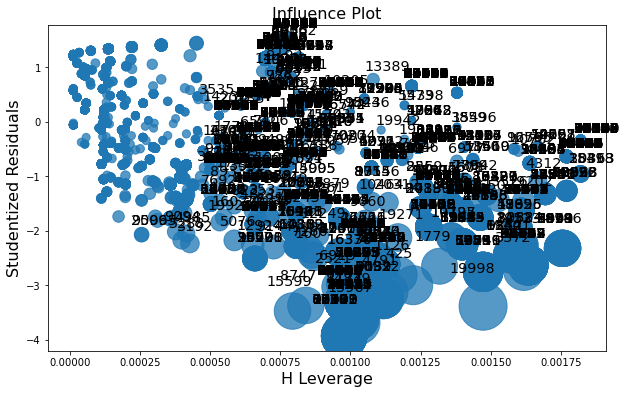

In [30]:
# visualize the influence from each borough
fig, ax = plt.subplots(figsize=(10,6))
fig = sm.graphics.influence_plot(model, ax=ax)

# Quantile map

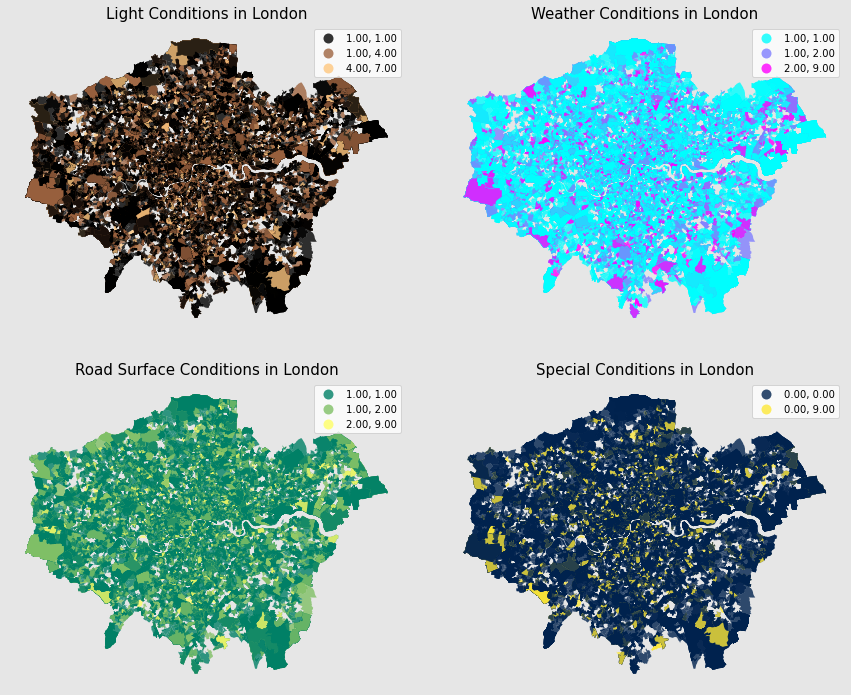

In [31]:
f, ax = plt.subplots(2,2,figsize=(15, 15))
# Set up figure and axis
# figure1
df1.plot(column='light_conditions', alpha=0.8, cmap='copper', scheme='quantiles', ax=ax[0][0],legend=True)
ax[0][0].set_title('Light Conditions in London', size=15)
ax[0][0].set_axis_off()
# figure2
df1.plot(column='weather_conditions', alpha=0.8, cmap='cool', scheme='quantiles', ax=ax[0][1],legend=True)
ax[0][1].set_title('Weather Conditions in London', size=15)
ax[0][1].set_axis_off()
# figure1
df1.plot(column='road_surface_conditions', alpha=0.8, cmap='summer', scheme='quantiles', ax=ax[1][0],legend=True)
ax[1][0].set_title('Road Surface Conditions in London', size=15)
ax[1][0].set_axis_off()
# figure1
df1.plot(column='special_conditions_at_site', alpha=0.8, cmap='cividis', scheme='quantiles', ax=ax[1][1],legend=True)
ax[1][1].set_title('Special Conditions in London', size=15)
ax[1][1].set_axis_off()

# Change background color of the figure
f.set_facecolor('0.9')
# set up the title
#f.suptitle('Light Conditions in London', size=25)
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=-0.3)
plt.show()

In [32]:
# Create the spatial weights matrix
w_queen = Queen.from_dataframe(df1)
w_queen.n
#w_queen.transform = 'R'

20971

In [33]:
#w_queen.histogram # frequency of n neighbors 

In [34]:
mi = esda.moran.Moran(df1['accident_severity'], w_queen) # call moran function
# print out the moran's I value
print("Moran'I: ",mi.I)
print("Moran'p_sim: ",mi.p_sim)

Moran'I:  0.00646500540467509
Moran'p_sim:  0.001


Text(0.5, 0, "Moran's I")

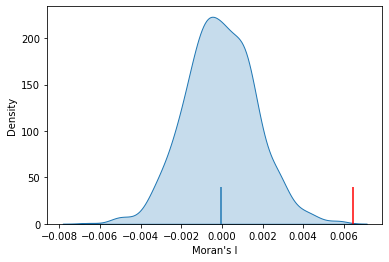

In [35]:
sns.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 40, color='r')
plt.vlines(mi.EI, 0, 40)
plt.xlabel("Moran's I")

# Spatial Local Autocorrelation for Accidents Severity

In [36]:
lisa = esda.Moran_Local(df1['accident_severity'].values, w_queen, permutations=999)
lisa.Is

array([-0.19578321, -0.19578321,  1.09856909, ..., -0.08493087,
        0.10680501,  0.10680501])

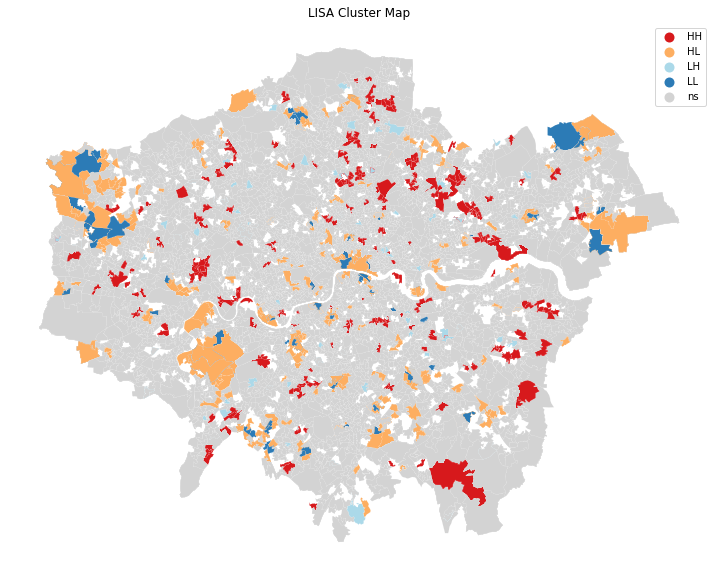

In [37]:
# cited from Week7 codes in Spatial Data Analysis(7CUSMSDA)
fig, ax=plt.subplots(1, figsize=(14,10))
fig = lisa_cluster(lisa, df1, ax=ax)
plt.title("LISA Cluster Map")
plt.show()